# Actividad - Proyecto práctico (Versión google colab)


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1: Andrés Solanes, Carles
*   Alumno 2: Barroso Galindo, José Manuel
*   Alumno 3: García González, Nestor
*   Alumno 4: Sánchez López, Roberto





---
## **PARTE 1** - Instalación y requisitos previos


---
### 1.1. Instalar librerías necesarias

In [1]:
#1. Ejecutar esta celda individualmente
#2. Reiniciar entorno cuando se solicite
#3. Ejecutar desde la siguiente celda en adelante

%pip install gym==0.17.3
%pip install git+https://github.com/Kojoley/atari-py.git
%pip install keras-rl2==1.0.5
%pip install tensorflow==2.12

  Cloning https://github.com/Kojoley/atari-py.git to /tmp/pip-req-build-6pwmpszt
  Running command git clone --filter=blob:none --quiet https://github.com/Kojoley/atari-py.git /tmp/pip-req-build-6pwmpszt
  Resolved https://github.com/Kojoley/atari-py.git to commit 86a1e05c0a95e9e6233c3a413521fdb34ca8a089
  Preparing metadata (setup.py) ... done


---
### 1.2. Localizar entorno de trabajo

In [2]:
mount='/content/gdrive'
drive_root = mount + "/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico"
from google.colab import drive
IN_COLAB=True


---
### 1.3. Montar carpeta de datos local

In [3]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico  exists.

Colab: Changing directory to  /content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico
/content/gdrive/My Drive/Colab Notebooks/08_MIAR/actividades/proyecto practico
Archivos en el directorio: 
[]


---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [4]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

#### Configuración base

In [5]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [6]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

1. Implementación de la red neuronal

In [7]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=(WINDOW_LENGTH,) + INPUT_SHAPE))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

2. Implementación de la solución DQN

In [8]:
#1. Memory (Replay buffer)
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

#2. Exploration policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

#3. Definición del agente
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=AtariProcessor(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

dqn.compile(Adam(learning_rate=0.00025), metrics=['mae'])

In [9]:
# Directorio donde guardar los archivos
weights_prefix = drive_root + f'/checkpoints/dqn_{env_name}_weights'

# Callback para guardar cada 50.000 pasos
checkpoint_callback = ModelIntervalCheckpoint(weights_prefix + '_{step}.h5f', interval=50000)

# Callback para logs de entrenamiento
log_filename = drive_root + f'/dqn_{env_name}_log.json'
log_callback = FileLogger(log_filename, interval=100)

# Lista de callbacks
callbacks = [checkpoint_callback, log_callback]

# Entrenamiento del modelo
dqn.fit(env, nb_steps=1750000, visualize=False, verbose=2, callbacks=callbacks)

# Reanudar desde un checkpoint
#dqn.load_weights(drive_root + '/checkpoints/dqn_SpaceInvaders-v0_weights_750000.h5f')
#dqn.fit(env, nb_steps=1000000, visualize=False, verbose=2, callbacks=callbacks)

# Guardar pesos finales
final_weights = drive_root + f'/dqn_{env_name}_weights_final.h5f'
dqn.save_weights(final_weights, overwrite=True)


Training for 1750000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     420/1750000: episode: 1, duration: 1.818s, episode steps: 420, steps per second: 231, episode reward:  6.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.479 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    1131/1750000: episode: 2, duration: 2.840s, episode steps: 711, steps per second: 250, episode reward:  7.000, mean reward:  0.010 [ 0.000,  1.000], mean action: 2.415 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    1941/1750000: episode: 3, duration: 3.235s, episode steps: 810, steps per second: 250, episode reward: 10.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.410 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    2827/1750000: episode: 4, duration: 3.574s, episode steps: 886, steps per second: 248, episode reward: 11.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.392 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    3345/1750000: episode: 5, duration: 2.100s, episode steps: 518, 

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   50232/1750000: episode: 70, duration: 8.633s, episode steps: 562, steps per second:  65, episode reward:  8.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.573 [0.000, 5.000],  loss: 0.006738, mae: 0.029235, mean_q: 0.053204, mean_eps: 0.954896
   50725/1750000: episode: 71, duration: 14.002s, episode steps: 493, steps per second:  35, episode reward: 10.000, mean reward:  0.020 [ 0.000,  1.000], mean action: 2.582 [0.000, 5.000],  loss: 0.007161, mae: 0.028636, mean_q: 0.046133, mean_eps: 0.954570
   51650/1750000: episode: 72, duration: 26.268s, episode steps: 925, steps per second:  35, episode reward: 14.000, mean reward:  0.015 [ 0.000,  1.000], mean action: 2.430 [0.000, 5.000],  loss: 0.005849, mae: 0.027845, mean_q: 0.041624, mean_eps: 0.953931
   52714/1750000: episode: 73, duration: 30.101s, episode steps: 1064, steps per second:  35, episode reward:  9.000, mean reward:  0.008 [ 0.000,  1.000], mean action: 2.520 [0.000, 5.000],  loss: 0.007656, mae: 0.032401, m

In [12]:
# Testing part to calculate the mean reward
dqn.load_weights(final_weights)
dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: 10.000, steps: 654
Episode 2: reward: 10.000, steps: 813
Episode 3: reward: 14.000, steps: 741
Episode 4: reward: 5.000, steps: 507
Episode 5: reward: 15.000, steps: 581
Episode 6: reward: 9.000, steps: 662
Episode 7: reward: 19.000, steps: 788
Episode 8: reward: 7.000, steps: 472
Episode 9: reward: 19.000, steps: 1016
Episode 10: reward: 10.000, steps: 670


3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---

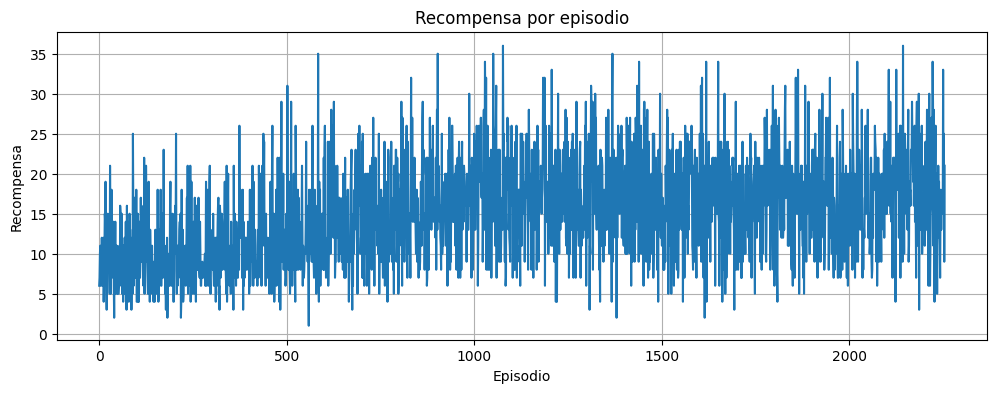

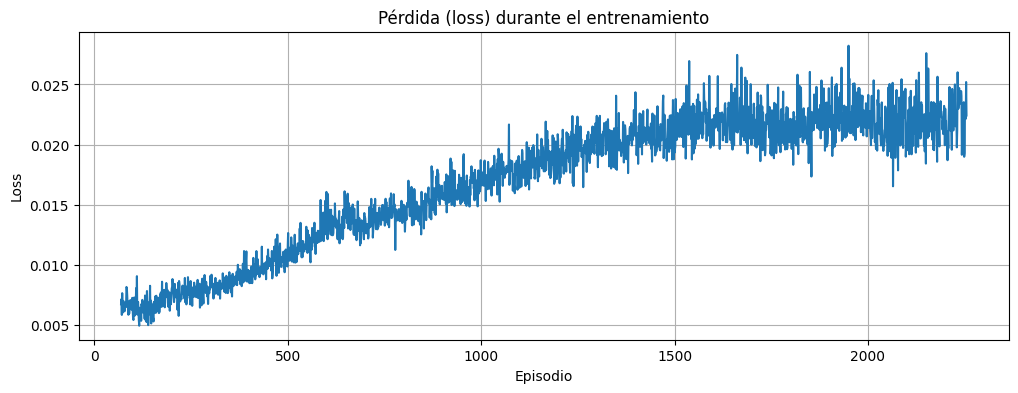

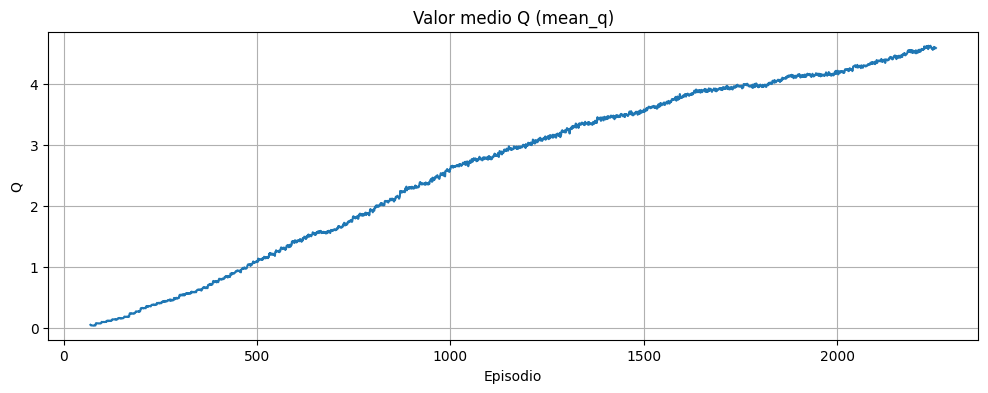

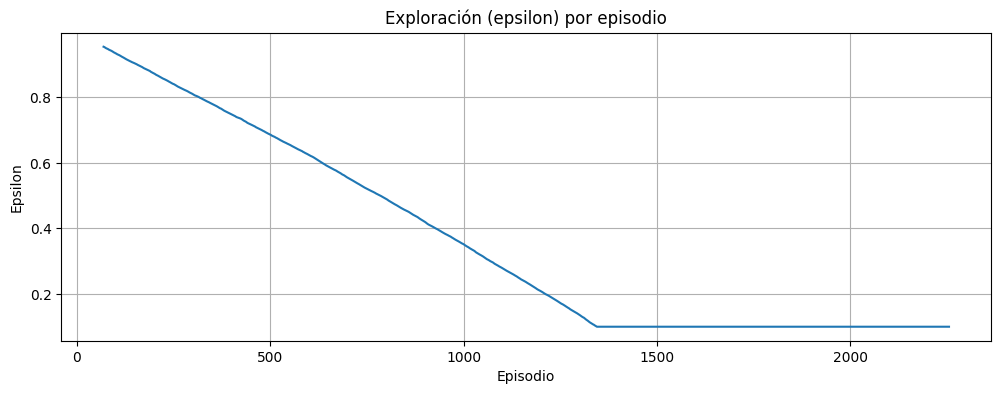

In [11]:
import json
import matplotlib.pyplot as plt

# Ruta al archivo log en Google Drive
log_path = drive_root + f'/dqn_{env_name}_log.json'

# Cargar los datos del archivo JSON
with open(log_path, 'r') as f:
    history = json.load(f)

# Extraer métricas
rewards = history['episode_reward']
losses = history.get('loss', [])
mean_qs = history.get('mean_q', [])
mean_eps = history.get('mean_eps', [])

# Gráfica de recompensas
plt.figure(figsize=(12, 4))
plt.plot(rewards)
plt.title('Recompensa por episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.grid(True)
plt.show()

# Gráfica de pérdida si está disponible
if losses:
    plt.figure(figsize=(12, 4))
    plt.plot(losses)
    plt.title('Pérdida (loss) durante el entrenamiento')
    plt.xlabel('Episodio')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Gráfica de mean_q
if mean_qs:
    plt.figure(figsize=(12, 4))
    plt.plot(mean_qs)
    plt.title('Valor medio Q (mean_q)')
    plt.xlabel('Episodio')
    plt.ylabel('Q')
    plt.grid(True)
    plt.show()

# Gráfica de epsilon
if mean_eps:
    plt.figure(figsize=(12, 4))
    plt.plot(mean_eps)
    plt.title('Exploración (epsilon) por episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Epsilon')
    plt.grid(True)
    plt.show()
